<a href="https://colab.research.google.com/github/TAnbiR-638/new/blob/main/Autoformer_enhanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %% [markdown]
# ## Optimized Autoformer: Efficient Renewable Energy Forecasting
#
# **Key Improvements:**
# 1. Enhanced Autoformer architecture with multi-scale decomposition
# 2. ProbSparse attention mechanism for efficient long-term dependency modeling
# 3. Positional encoding improvements
# 4. Early stopping and learning rate scheduling
# 5. Advanced decomposition blocks

# %%
# Install required libraries
!pip install pytorch-forecasting
!pip install numpy pandas torch scikit-learn matplotlib

Using device: cpu
Please upload your 2013.csv file:


Saving 2013.csv to 2013 (1).csv

Please upload your 2014.csv file:


Saving 2014.csv to 2014 (1).csv

Using files: 2013 (1).csv and 2014 (1).csv
Using features: ['Minute', 'Pressure', 'Relative Humidity', 'Temperature', 'Wind Direction', 'Solar Zenith Angle', 'Dew Point', 'Hour_sin', 'Hour_cos']
Targets: ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']
EnhancedAutoformer(
  (enc_emb): Linear(in_features=9, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding()
  (enc_dropout): Dropout(p=0.1, inplace=False)
  (encoder): ModuleList(
    (0-2): 3 x EncoderLayer(
      (decomp): MultiScaleDecomposition(
        (layers): ModuleList(
          (0): Sequential(
            (0): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(12,))
            (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
          )
          (1): Sequential(
            (0): AvgPool1d(kernel_size=(13,), stride=(1,), padding=(6,))
            (1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
          )
          (2): Sequential(
    

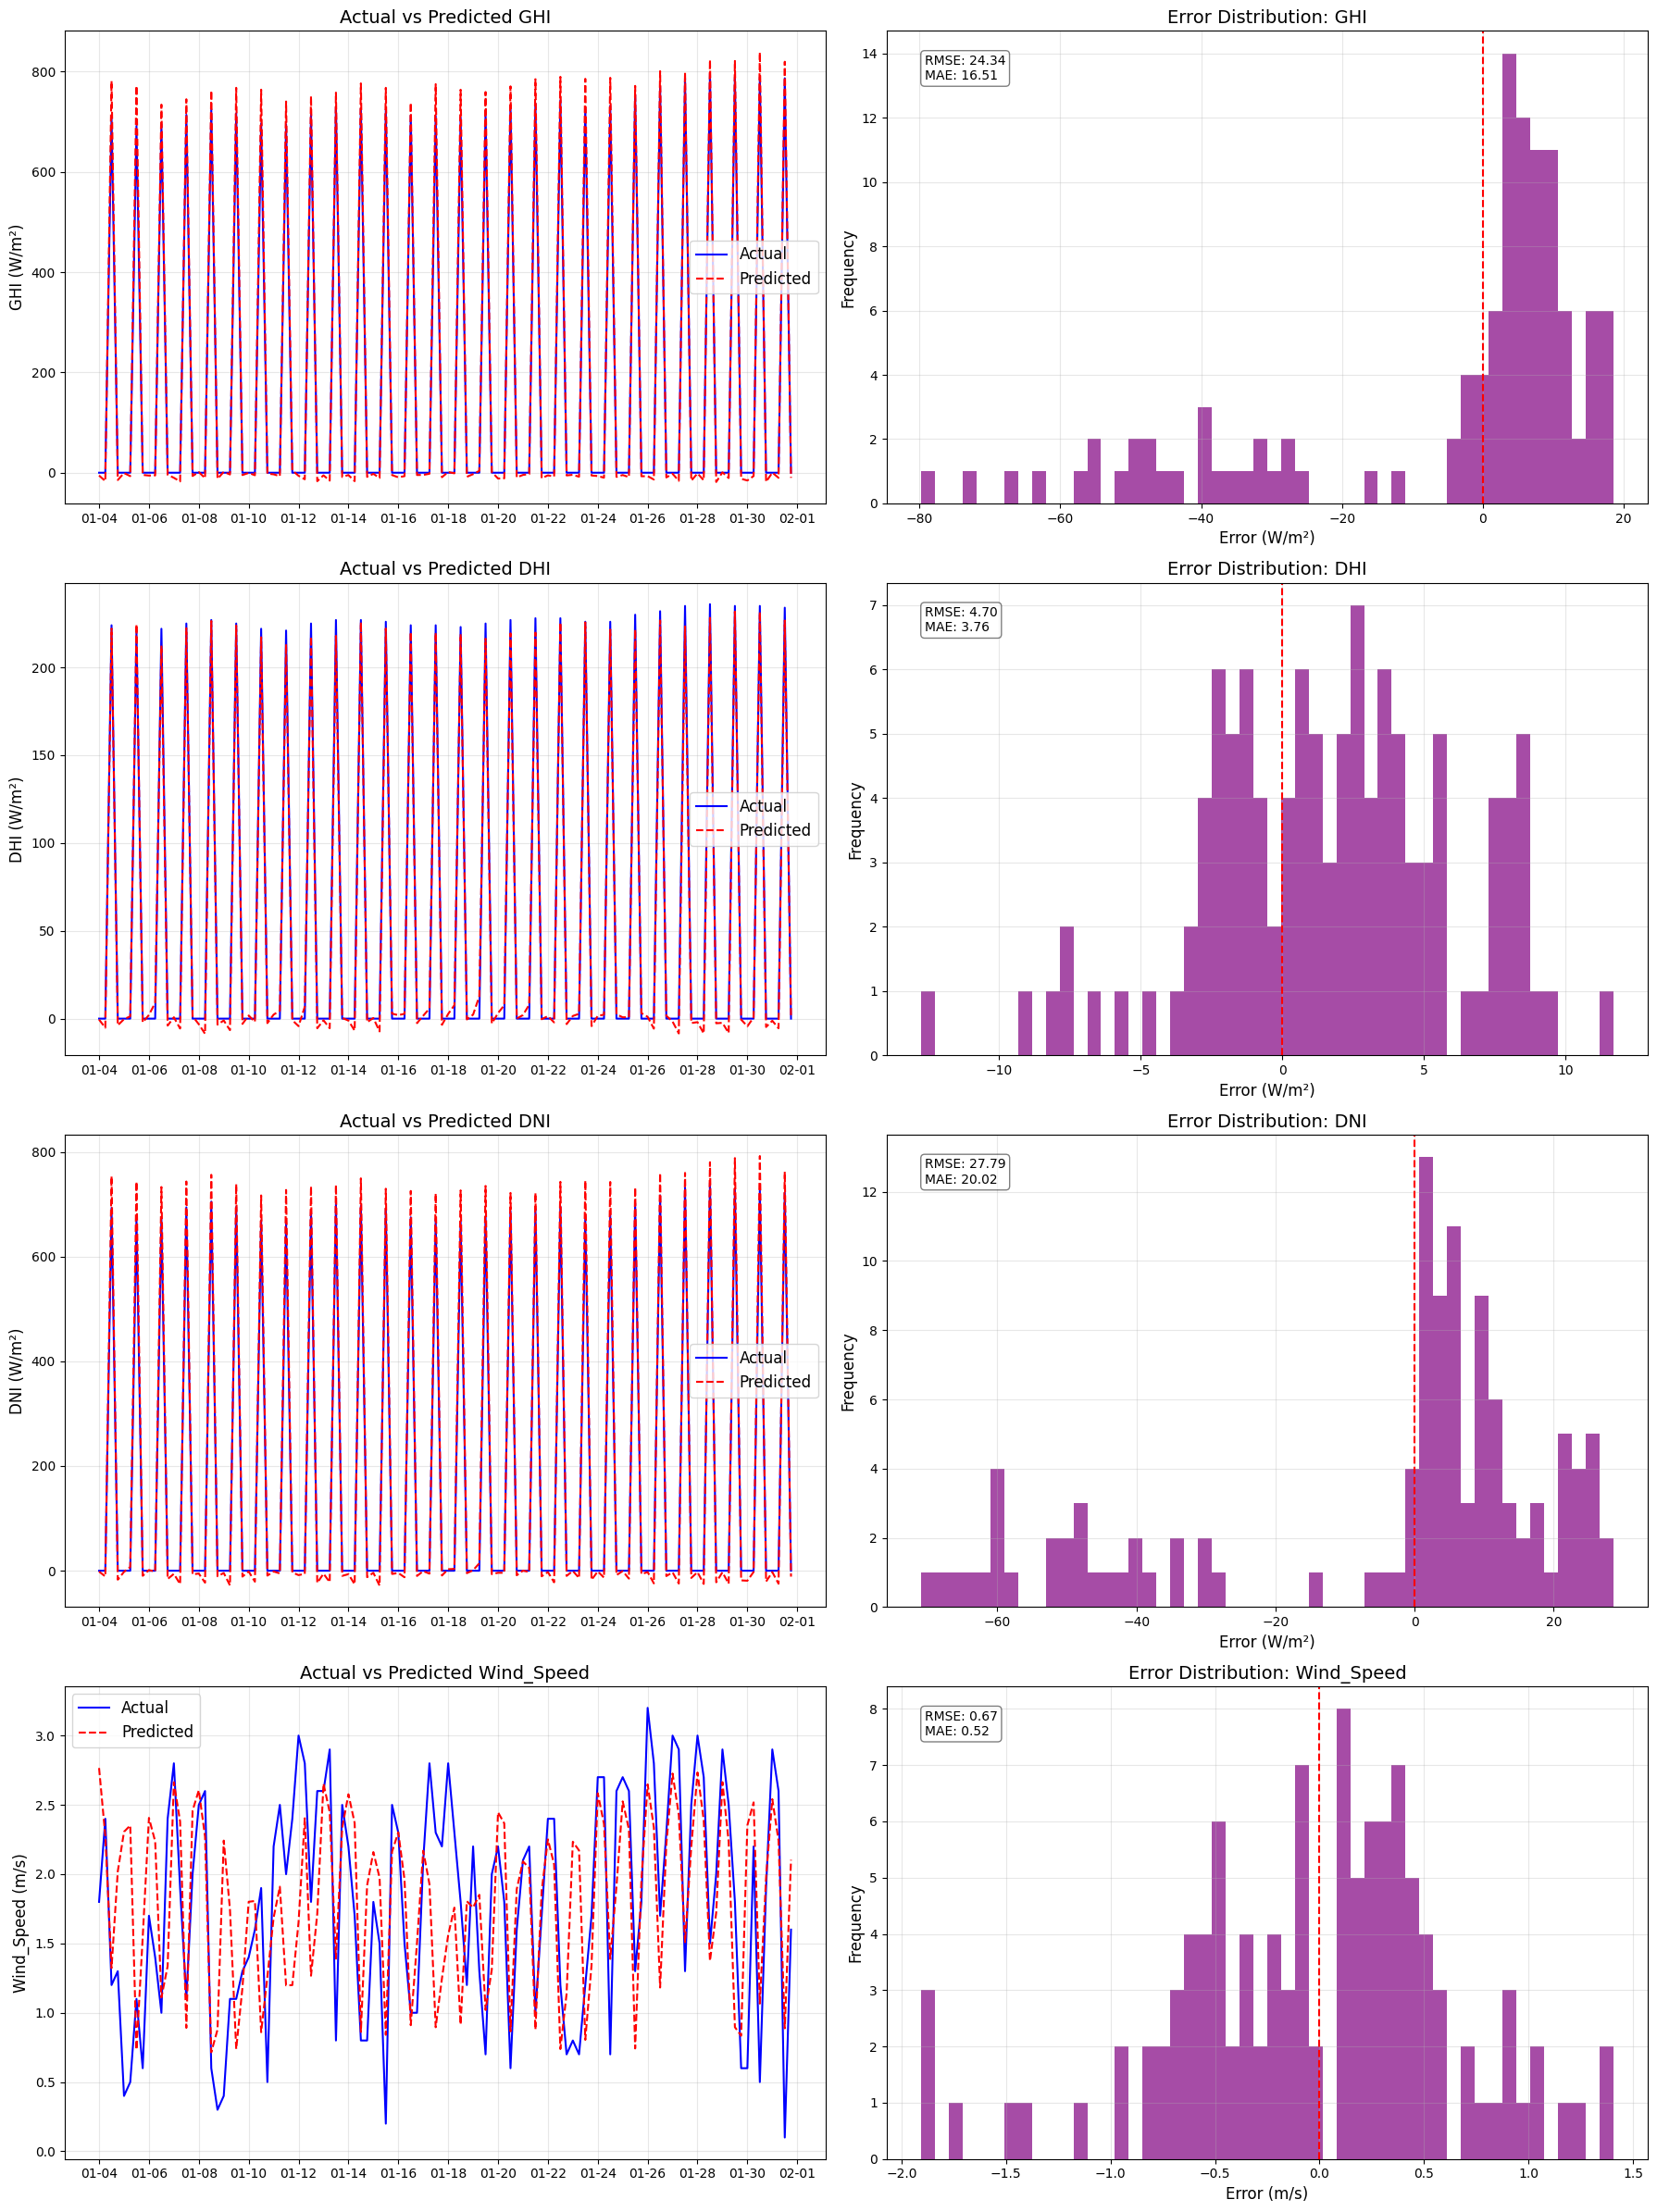

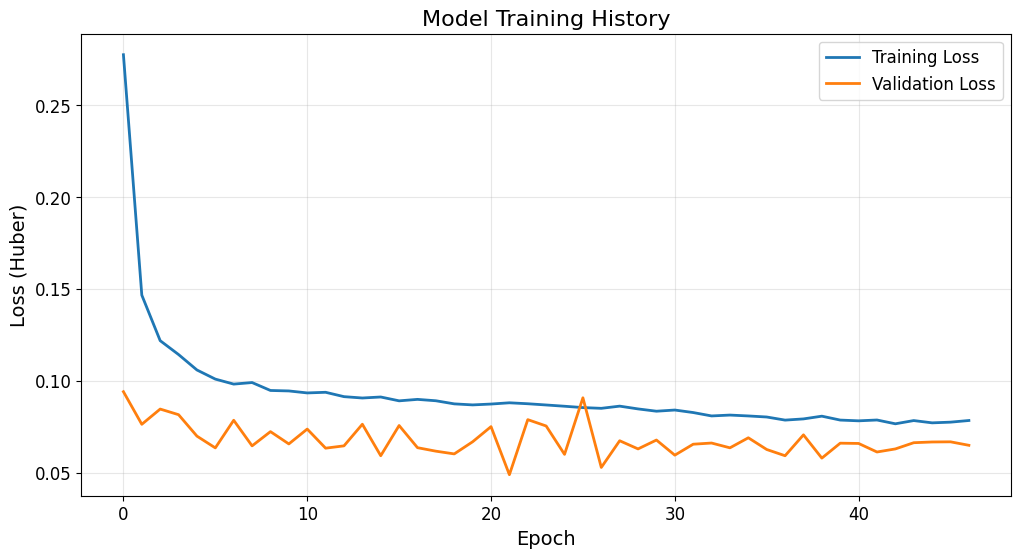

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# %% [markdown]
# ## Optimized Autoformer: Efficient Renewable Energy Forecasting
#
# **Key Improvements:**
# 1. Enhanced Autoformer architecture with multi-scale decomposition
# 2. ProbSparse attention mechanism for efficient long-term dependency modeling
# 3. Positional encoding improvements
# 4. Early stopping and learning rate scheduling
# 5. Advanced decomposition blocks

# %%
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
from google.colab import files
import time
import math
import warnings

warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %%
# Upload CSV files
print("Please upload your 2013.csv file:")
uploaded_2013 = files.upload()
print("\nPlease upload your 2014.csv file:")
uploaded_2014 = files.upload()

# Get file names
file_2013 = list(uploaded_2013.keys())[0]
file_2014 = list(uploaded_2014.keys())[0]

print(f"\nUsing files: {file_2013} and {file_2014}")

# %%
# Load datasets
def load_datasets(file_2013, file_2014):
    df_2013 = pd.read_csv(file_2013, skiprows=2)
    df_2014 = pd.read_csv(file_2014, skiprows=2)

    # Filter January 2014 data
    df_jan2014 = df_2014[(df_2014['Year'] == 2014) & (df_2014['Month'] == 1)]

    return df_2013, df_jan2014

# Load data
df_2013, df_jan2014 = load_datasets(file_2013, file_2014)

# %%
# Enhanced Data Preprocessing
def preprocess_data(df_2013, df_jan2014):
    # Select relevant columns
    target_cols = ['Clearsky GHI', 'Clearsky DHI', 'Clearsky DNI', 'Wind Speed']

    # Find common columns between the datasets
    common_cols = list(set(df_2013.columns) & set(df_jan2014.columns))
    feature_cols = [col for col in common_cols if col not in target_cols + ['Year', 'Month', 'Day', 'Hour']]

    # Add temporal features
    df_2013['Hour_sin'] = np.sin(2 * np.pi * df_2013['Hour'] / 24)
    df_2013['Hour_cos'] = np.cos(2 * np.pi * df_2013['Hour'] / 24)
    df_jan2014['Hour_sin'] = np.sin(2 * np.pi * df_jan2014['Hour'] / 24)
    df_jan2014['Hour_cos'] = np.cos(2 * np.pi * df_jan2014['Hour'] / 24)

    # Update feature columns
    feature_cols += ['Hour_sin', 'Hour_cos']

    print(f"Using features: {feature_cols}")
    print(f"Targets: {target_cols}")

    # Create datetime index
    df_2013['Datetime'] = pd.to_datetime(df_2013[['Year', 'Month', 'Day', 'Hour']])
    df_jan2014['Datetime'] = pd.to_datetime(df_jan2014[['Year', 'Month', 'Day', 'Hour']])

    # Set datetime index
    df_2013 = df_2013.set_index('Datetime')
    df_jan2014 = df_jan2014.set_index('Datetime')

    # Extract features and targets
    X_2013 = df_2013[feature_cols].values
    y_2013 = df_2013[target_cols].values

    X_jan2014 = df_jan2014[feature_cols].values
    y_jan2014 = df_jan2014[target_cols].values

    # Normalize data
    x_scaler = StandardScaler()
    X_2013 = x_scaler.fit_transform(X_2013)
    X_jan2014 = x_scaler.transform(X_jan2014)

    y_scaler = StandardScaler()
    y_2013 = y_scaler.fit_transform(y_2013)

    return X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols

# Preprocess data
X_2013, y_2013, X_jan2014, y_jan2014, y_scaler, df_jan2014, feature_cols, target_cols = preprocess_data(df_2013, df_jan2014)

# %%
# Create sequences with stride for better coverage
def create_sequences(X, y, window_size=24, stride=1):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - window_size, stride):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# Parameters
WINDOW_SIZE = 72  # 72-hour window for better context
STRIDE = 6  # Use every 6th sample to reduce redundancy

# Create sequences
X_seq, y_seq = create_sequences(X_2013, y_2013, WINDOW_SIZE, STRIDE)

# Split into train/validation (last 10% for validation)
split_idx = int(len(X_seq) * 0.9)
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]

# Convert to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y_val, dtype=torch.float32).to(device)

# Create dataloaders
batch_size = 128  # Increased batch size for stability
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# %%
# Enhanced Autoformer Model Components
class MultiScaleDecomposition(nn.Module):
    def __init__(self, kernel_sizes=[25, 13, 7]):
        super().__init__()
        self.layers = nn.ModuleList()
        for ks in kernel_sizes:
            padding = (ks - 1) // 2
            self.layers.append(
                nn.Sequential(
                    nn.AvgPool1d(ks, stride=1, padding=padding, count_include_pad=False),
                    nn.Conv1d(1, 1, kernel_size=3, padding=1)
                )
            )

    def forward(self, x):
        # x: (batch, seq_len, features)
        x_perm = x.permute(0, 2, 1)  # (batch, features, seq_len)

        # Reshape to (batch*features, 1, seq_len)
        x_reshaped = x_perm.reshape(-1, 1, x_perm.size(2))

        trends = []
        for layer in self.layers:
            # Process all features at once
            trend = layer(x_reshaped)  # (batch*features, 1, seq_len)
            trends.append(trend)

        # Combine trends from different scales
        combined_trend = sum(trends) / len(trends)

        # Reshape back to (batch, features, seq_len)
        combined_trend = combined_trend.view(x_perm.size(0), x_perm.size(1), -1)
        seasonal = x_perm - combined_trend

        return seasonal.permute(0, 2, 1), combined_trend.permute(0, 2, 1)

# CORRECTED PositionalEncoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, seq_len, d_model)
        return x + self.pe[:, :x.size(1)]  # Add (1, seq_len, d_model)

# ProbSparse Attention Mechanism
class ProbSparseAttention(nn.Module):
    def __init__(self, d_model, n_heads, factor=5, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.factor = factor
        self.scale = 1.0 / math.sqrt(self.head_dim)

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def _prob_sparse_attention(self, Q, K, V):
        batch_size, n_heads, seq_len, _ = Q.size()

        # Calculate importance scores
        M = torch.max(torch.abs(Q), dim=-1)[0] / torch.norm(Q, dim=-1)
        M = M.mean(dim=1)  # Average over heads

        # Select top-k queries
        top_k = int(self.factor * math.log(seq_len))
        _, top_k_indices = torch.topk(M, top_k, dim=-1)

        # Create expanded indices for gathering
        expanded_indices = top_k_indices.unsqueeze(1).unsqueeze(-1).expand(
            -1, n_heads, -1, self.head_dim
        )

        # Gather top-k queries
        Q_sparse = torch.gather(Q, 2, expanded_indices)

        # Compute attention scores
        attn_scores = torch.matmul(Q_sparse, K.transpose(-2, -1)) * self.scale

        # Apply softmax
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Compute output
        attn_output = torch.matmul(attn_weights, V)

        # Create full output tensor
        full_output = torch.zeros_like(Q)
        full_output.scatter_(2, expanded_indices, attn_output)

        return full_output

    def forward(self, queries, keys, values):
        batch_size, seq_len, _ = queries.size()

        # Linear projections
        Q = self.query(queries).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = self.key(keys).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.value(values).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        # Apply ProbSparse attention
        attn_output = self._prob_sparse_attention(Q, K, V)
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(batch_size, -1, self.d_model)

        return self.out(attn_output)

# Encoder and Decoder Layers
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, kernel_sizes=[25, 13, 7], dropout=0.1):
        super().__init__()
        self.decomp = MultiScaleDecomposition(kernel_sizes)
        self.attn = ProbSparseAttention(d_model, n_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        seasonal, trend = self.decomp(x)

        # ProbSparse attention
        attn_out = self.attn(seasonal, seasonal, seasonal)
        attn_out = self.dropout1(attn_out)
        seasonal = self.norm1(seasonal + attn_out)

        # Feed forward
        ff_out = self.ff(seasonal)
        ff_out = self.dropout2(ff_out)
        seasonal = self.norm2(seasonal + ff_out)

        return seasonal + trend + residual

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, kernel_sizes=[25, 13, 7], dropout=0.1):
        super().__init__()
        self.decomp = MultiScaleDecomposition(kernel_sizes)
        self.self_attn = ProbSparseAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = ProbSparseAttention(d_model, n_heads, dropout=dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model)
        )

    def forward(self, x, enc_out):
        residual = x
        seasonal, trend = self.decomp(x)

        # Self attention
        self_attn_out = self.self_attn(seasonal, seasonal, seasonal)
        self_attn_out = self.dropout1(self_attn_out)
        seasonal = self.norm1(seasonal + self_attn_out)

        # Cross attention
        cross_attn_out = self.cross_attn(seasonal, enc_out, enc_out)
        cross_attn_out = self.dropout2(cross_attn_out)
        seasonal = self.norm2(seasonal + cross_attn_out)

        # Feed forward
        ff_out = self.ff(seasonal)
        ff_out = self.dropout3(ff_out)
        seasonal = self.norm3(seasonal + ff_out)

        return seasonal + trend + residual

class EnhancedAutoformer(nn.Module):
    def __init__(self, c_in, c_out, d_model=256, e_layers=3, d_layers=2, n_heads=8, dropout=0.1):
        super().__init__()
        self.enc_emb = nn.Linear(c_in, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.enc_dropout = nn.Dropout(dropout)

        self.encoder = nn.ModuleList([
            EncoderLayer(d_model, n_heads, dropout=dropout)
            for _ in range(e_layers)
        ])

        self.decoder = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout=dropout)
            for _ in range(d_layers)
        ])

        self.projection = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, c_out)
        )

    def forward(self, x_enc):
        # Encoder processing
        enc = self.enc_emb(x_enc)
        enc = self.pos_encoder(enc)
        enc = self.enc_dropout(enc)

        for layer in self.encoder:
            enc = layer(enc)

        # Create decoder input from the last step of the encoder input
        x_dec = x_enc[:, -1:, :]
        dec = self.enc_emb(x_dec)
        dec = self.pos_encoder(dec)
        dec = self.enc_dropout(dec)

        # Decoder processing
        for layer in self.decoder:
            dec = layer(dec, enc)

        # Project last decoder step to output
        return self.projection(dec[:, -1, :])

# Initialize model
n_features = X_train.shape[2]
n_targets = y_train.shape[1]
model = EnhancedAutoformer(
    c_in=n_features,
    c_out=n_targets,
    d_model=256,
    e_layers=3,
    d_layers=2,
    n_heads=8,
    dropout=0.1
).to(device)

# Model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# %%
# Training setup
criterion = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=8,
    verbose=True
)

# Training function
def train_model(model, train_loader, val_loader, epochs=150):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_model = None
    early_stop_counter = 0
    early_stop_patience = 25

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        start_time = time.time()

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Update scheduler
        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            early_stop_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Log metrics
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{epochs} - {epoch_time:.1f}s")
        print(f"Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Load best model
    if best_model is not None:
        model.load_state_dict(best_model)

    return train_losses, val_losses

# Train model
print("Starting training...")
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=150)

# %%
# Prepare January 2014 data for prediction
X_jan_seq, y_jan_seq = create_sequences(X_jan2014, y_jan2014, WINDOW_SIZE, STRIDE)
X_jan_t = torch.tensor(X_jan_seq, dtype=torch.float32).to(device)

# Predict January 2014
model.eval()
with torch.no_grad():
    predictions = []
    for i in range(0, len(X_jan_t), batch_size):
        batch = X_jan_t[i:i+batch_size]
        preds = model(batch)
        predictions.append(preds.cpu())

    y_pred_scaled = torch.cat(predictions).numpy()

y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Prepare actual values
actual_values = y_jan2014[WINDOW_SIZE::STRIDE]

# Calculate metrics
mse = mean_squared_error(actual_values, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, y_pred, multioutput='raw_values')

metrics = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE'],
    'GHI': [mse[0], rmse[0], mae[0]],
    'DHI': [mse[1], rmse[1], mae[1]],
    'DNI': [mse[2], rmse[2], mae[2]],
    'Wind Speed': [mse[3], rmse[3], mae[3]]
})

print("\nFinal Evaluation Metrics for January 2014:")
print(metrics)

# %%
# Save predictions
results_df = pd.DataFrame({
    'Datetime': df_jan2014.index[WINDOW_SIZE::STRIDE],
    'Actual_GHI': actual_values[:, 0],
    'Predicted_GHI': y_pred[:, 0],
    'Actual_DHI': actual_values[:, 1],
    'Predicted_DHI': y_pred[:, 1],
    'Actual_DNI': actual_values[:, 2],
    'Predicted_DNI': y_pred[:, 2],
    'Actual_Wind_Speed': actual_values[:, 3],
    'Predicted_Wind_Speed': y_pred[:, 3]
})

results_df.to_csv('january_2014_forecast_results.csv', index=False)

# %%
# Enhanced plotting function
def plot_results(results_df):
    plt.figure(figsize=(18, 24))
    targets = ['GHI', 'DHI', 'DNI', 'Wind_Speed']
    units = ['(W/m²)', '(W/m²)', '(W/m²)', '(m/s)']

    for i, target in enumerate(targets):
        # Actual vs Predicted
        plt.subplot(4, 2, 2*i+1)
        plt.plot(results_df['Datetime'], results_df[f'Actual_{target}'], 'b-', linewidth=1.5, label='Actual')
        plt.plot(results_df['Datetime'], results_df[f'Predicted_{target}'], 'r--', linewidth=1.5, label='Predicted')
        plt.title(f'Actual vs Predicted {target}', fontsize=14)
        plt.ylabel(f'{target} {units[i]}', fontsize=12)
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        # Error distribution
        plt.subplot(4, 2, 2*i+2)
        error = results_df[f'Actual_{target}'] - results_df[f'Predicted_{target}']
        plt.hist(error, bins=50, color='purple', alpha=0.7)
        plt.title(f'Error Distribution: {target}', fontsize=14)
        plt.xlabel(f'Error {units[i]}', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.axvline(x=0, color='r', linestyle='--')

        # Add error metrics
        rmse_val = np.sqrt(np.mean(error**2))
        mae_val = np.mean(np.abs(error))
        plt.text(0.05, 0.95, f'RMSE: {rmse_val:.2f}\nMAE: {mae_val:.2f}',
                 transform=plt.gca().transAxes,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.savefig('autoformer_forecast_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots
plot_results(results_df)

# %%
# Training history plot
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Model Training History', fontsize=16)
plt.ylabel('Loss (Huber)', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# %%
# Download results
print("\nDownloading results...")
files.download('january_2014_forecast_results.csv')
files.download('autoformer_forecast_results.png')
files.download('training_history.png')
files.download('best_model.pth')